In [24]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

import glob, os
import matplotlib
import tensorflow as tf
print (matplotlib.__version__)

3.2.2


In [25]:
def convert_tb_data(root_dir, sort_by=None, exp_name=''):
    """Convert local TensorBoard data into Pandas DataFrame.
    
    Function takes the root directory path and recursively parses
    all events data.    
    If the `sort_by` value is provided then it will use that column
    to sort values; typically `wall_time` or `step`.
    
    *Note* that the whole data is converted into a DataFrame.
    Depending on the data size this might take a while. If it takes
    too long then narrow it to some sub-directories.
    
    Paramters:
        root_dir: (str) path to root dir with tensorboard data.
        sort_by: (optional str) column name to sort by.
    
    Returns:
        pandas.DataFrame with [wall_time, name, step, value] columns.
    
    """
    import os
    import pandas as pd
    from tensorflow.python.summary.summary_iterator import summary_iterator
    import tensorflow as tf

    def convert_tfevent(filepath):
        return pd.DataFrame([
            parse_tfevent(e) for e in summary_iterator(filepath) if len(e.summary.value)
        ])

    def parse_tfevent(tfevent):
        # print(tfevent)
        # print(tf.make_ndarray(tfevent.summary.value[0].tensor))
        # assert 1==2
        return dict(
            wall_time=tfevent.wall_time,
            name=tfevent.summary.value[0].tag,
            step=tfevent.step,
            value=float(tf.make_ndarray(tfevent.summary.value[0].tensor)),
        )
    
    columns_order = ['wall_time', 'name', 'step', 'value']
    
    out = []
    for (root, _, filenames) in os.walk(root_dir):
        for filename in filenames:
            if "events.out.tfevents" not in filename:
                continue
            file_full_path = os.path.join(root, filename)
            out.append(convert_tfevent(file_full_path))

    # Concatenate (and sort) all partial individual dataframes
    all_df = pd.concat(out)[columns_order]
    if sort_by is not None:
        all_df = all_df.sort_values(sort_by)

    all_df.name = all_df.name.apply(lambda name: exp_name + "/" + name)
        
    return all_df.reset_index(drop=True)

def smooth(series, weight):
    last = series.iloc[0]
    smoothed = [last]
    for point in series[1:]:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return pd.Series(smoothed, index=series.index)

def plot_category(df, category_name, smoothing=0.25):
    # Get category data
    category_df = df[df.name.str.endswith(category_name)]
    # Smooth data by grouping it by experiment name
    groups = category_df.groupby('name')
    sr = groups.apply(lambda x: smooth(x["value"], weight=smoothing)).reset_index().set_index("level_1").drop(columns=["name"]).rename(columns={0:"ewm"})
    # sr = groups.apply(lambda x: x.value.ewm(alpha=smoothing, adjust=False).mean()).reset_index().set_index("level_1").drop(columns=["name"]).rename(columns={"value":"ewm"})
    out = pd.merge(category_df, sr, left_index=True, right_index=True)
    # Define aggregation indicator by experiment name e.g., "exp_name__0", "exp_name__1", ...
    indicator = out.name.apply(lambda name: name.split("__")[0])
    # Plot 
    sns.lineplot(data=out, x="step", y="ewm", hue=indicator)

In [26]:
root_directory = "/home/cambel/trufus/good_hyper_results_50k/"
root_directory = "/home/cambel/Documents/peg-in-hole/hyper_params_100k/"
root_directory = "/home/cambel/Documents/peg-in-hole/teaching_mode/new_hard/csv_new_hard/" 
root_directory = "/home/cambel/Documents/peg-in-hole/TCN_vs_NN_results_50k/"
root_directory = "/root/trufus/results/"
root_directory = "/root/o2ac-ur/clean_results/"

directory_list = glob.glob(root_directory + "*/")
print(directory_list)

csv_list = glob.glob(root_directory + "*.csv")
print(csv_list)


['/root/o2ac-ur/clean_results/SAC_slicing_3d__S.069357/', '/root/o2ac-ur/clean_results/SAC_slicing_3d2__-S.402498/', '/root/o2ac-ur/clean_results/SAC_slicing_3d__S.880481/']
[]


In [27]:
all_data = []
for dir in directory_list:
    exp_name = dir.split("/")[-2]
    print(exp_name)
    all_data.append(convert_tb_data(dir, sort_by="step", exp_name=exp_name))
# for csv_file in csv_list:
#     all_data.append(pd.read_csv(csv_file))

df = pd.concat(all_data)

SAC_slicing_3d__S.069357
SAC_slicing_3d2__-S.402498
SAC_slicing_3d__S.880481


In [28]:
# plot_category(df, "Common/training_return", smoothing=0.999)
# plt.title("")
# plt.ylabel("Reward")
# plt.xlabel("Step")
# plt.grid()

In [29]:
# plot_category(df, "success_rate", smoothing=0.5)
# plt.title("")
# plt.ylabel("Success Rate")
# plt.xlabel("Step")
# plt.grid()

KeyError: "None of ['level_1'] are in the columns"

In [ ]:
# plot_category(df, "test_performance_metric", smoothing=0.7)
# plt.title("")
# plt.ylabel("Performance metric")
# plt.xlabel("Step")
# plt.grid()

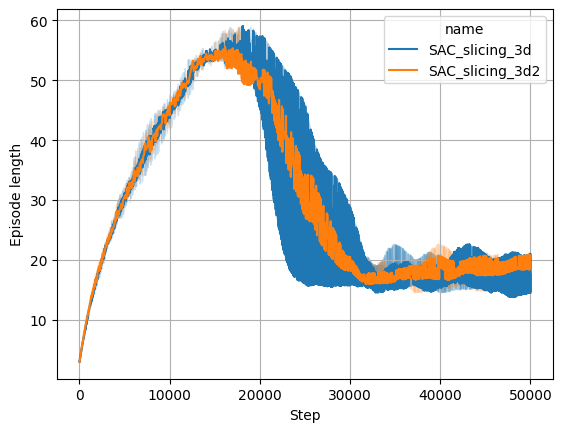

In [32]:
plot_category(df, "training_episode_length", smoothing=0.99)
plt.title("")
plt.ylabel("Episode length")
plt.xlabel("Step")
plt.grid()

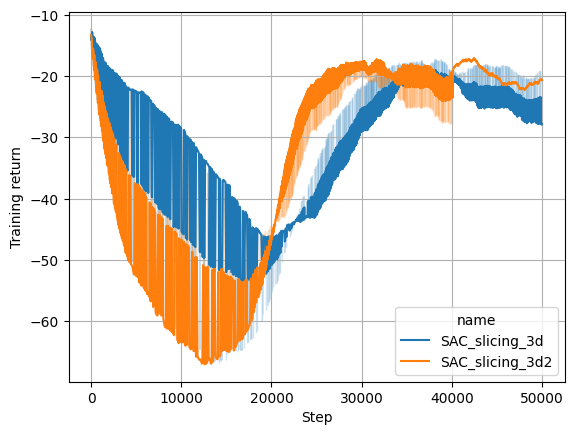

In [ ]:
plot_category(df, "training_return", smoothing=0.99)
plt.title("")
plt.ylabel("Training return")
plt.xlabel("Step")
plt.grid()